# Tutorial for EEG Multisensory Perception and Imagination Dataset

This tutorial provides a walkthrough for how to load, prepare, pre-process and conduct basic decoding on the multisensory perception and imagination dataset. So far the tutorial is only designed for one participant's session at a time. This is because data collection is still ongoing. 

1. Loading Data
2. Exploring Data
3. Cleaning Data
4. Feature Extraction
5. Feature Selection
6. Dimensionality Reductiong
7. Epoching
8. Classification

## The Dataset
This dataset has been created at the University of Bath, and collected by Holly Wilson, Jinha Yoon, Becky Dakin and Aneekha Bal. We use a 128 channel gel-based ANT-Neuro headset. Data is recorded at 1024 Hz. The amount of trials undertaken by participants varied as a function of their fatigue. Many participants requested to finish before completing the full experiment. Additionally, though all participants are requested to complete three sessions, the majority of participants completed 1-2 sessions. A baseline recording is taken during the 10 second countdown to the first trial, after the participant presses a space bar to begin the experiment. Breaks occur roughly every 7 minutes. The three semantic categories used are 'penguin', 'guitar' and 'flower'. The three sensory modalities include pictorial (visual), orthographic (visual) and speech (audio). The two tasks include perception and imagination. There are roughly 40 trials for each of the 18 conditions.

For further information regarding the experimental design, data collection and data preparation, contact hlw69@bath.ac.uk.  

In [1]:
# make sure you have mne, pandas, sklearn installed, you may also need pymatreader
import mne
from mne import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from mne.io import read_raw_eeglab
from mne.io import eeglab
import numpy as np

Participant specific information we can set below:

In [6]:
cap_size = 'medium' # either 'small', 'medium' or 'large'
ppt_num = '8'
session = '2' #either 1, 2 or 3

## (1) Loading Data
The eeg files are originally saved as a .cdf format specific to ANT-Neuro, it is not the same as the .cdf BrainVision formats. This means it cannot be directly loaded into python using mne. To make it compatiable, we first loaded it into EEGLAB then saved as a .set and .fdt file. The .fdt files contains the event information. However to load the data with mne we only need to call the .set file, as long as the .fdt is in the same folder it is loaded automatically alongside .set. Information about the events are captured as Annotations, which are different from Events. We later convert to Events, but note that there are differences, annotations units are seconds whereas Events are samples.

It is wise to sanity check properties of the data such as the sampling rate (should be 1024 hz), number of channels (should be 128 to begin with, then less once ECOG removed). 

Below we load the raw data, look at some of he information, and remove redundant electroculogram (EOG) electrodes. These electrodes, which are on long wires, are sometimes used for artifact removal or eye related movements. However, in our study we wanted to minimise any cables interfering with visual perception, therefore these electrodes were moved out of the way.

In [3]:
path = 'sub'+ppt_num+'_sess'+session+'.set' 
#path = 'D:\\EEG\\dummydata\\dummydata.set'
eog =  ['VEOGL', 'VEOGU', 'HEOGR', 'HEOGL'] # eye movement related electrodes
raw = read_raw_eeglab(path,preload=True, eog=eog) # creates two types, eeg and eog
print(raw)
print(raw.info)
raw.pick_types(eog=False, eeg=True) # ignore eog channels
print('Sample rate of the data is:', raw.info['sfreq'], 'Hz. It should be 1024 Hz')

Reading /mnt/seaweed/homes/hlw69/eeg_holly/sub8_sess2.fdt
Reading 0 ... 4685083  =      0.000 ...  4575.276 secs...


<ipython-input-3-13cbe2635735>:4: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['HEOGR', 'HEOGL', 'VEOGU', 'VEOGL']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(path,preload=True, eog=eog) # creates two types, eeg and eog


<RawEEGLAB | sub8_sess2.fdt, 128 x 4685084 (4575.3 s), ~4.47 GB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 124 EEG, 4 EOG
 custom_ref_applied: False
 dig: 124 items (124 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 1024.0 Hz
>
Sample rate of the data is: 1024.0 Hz. It should be 1024 Hz


# (2) Exploring the Data
##  Plotting the Raw Data
We need to plot the data to sanity check that it looks as we would expect. We also plot the data to check for artifacts, as discussed in the next step. Note that when plotting, EEG channels are black, whereas MEG are blue. This means your plots will look different to tutorials online. Your plots will not automatically be interactive. To make them so, use %matplotlib qt on the preceeding line.This will enable you to scroll through your plots.

Plot_psd plots the power spectral density, it can be considered as a histrogram for frequency information. You may see a spike around 50-60Hz, which is likely due to powerlines. We later filter this out.

Negative values on the decibal scale mean the power is less than the reference power. Higher decibal values mean a more powerful signal.

Effective window size : 2.000 (s)


<ipython-input-4-2e13b4ee0818>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd = raw.plot_psd(fmin = 0,fmax=100, spatial_colors=True) # plots the power spectral density, only those below 50 Hz:  n_fft=2048,


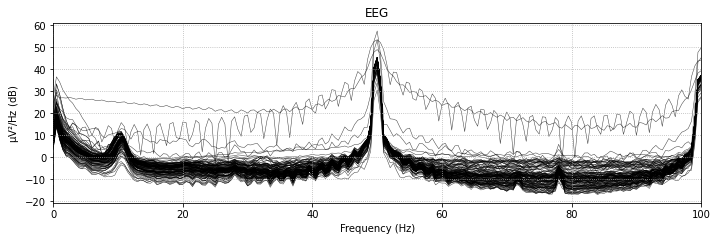

Using matplotlib as 2D backend.
Opening raw-browser...


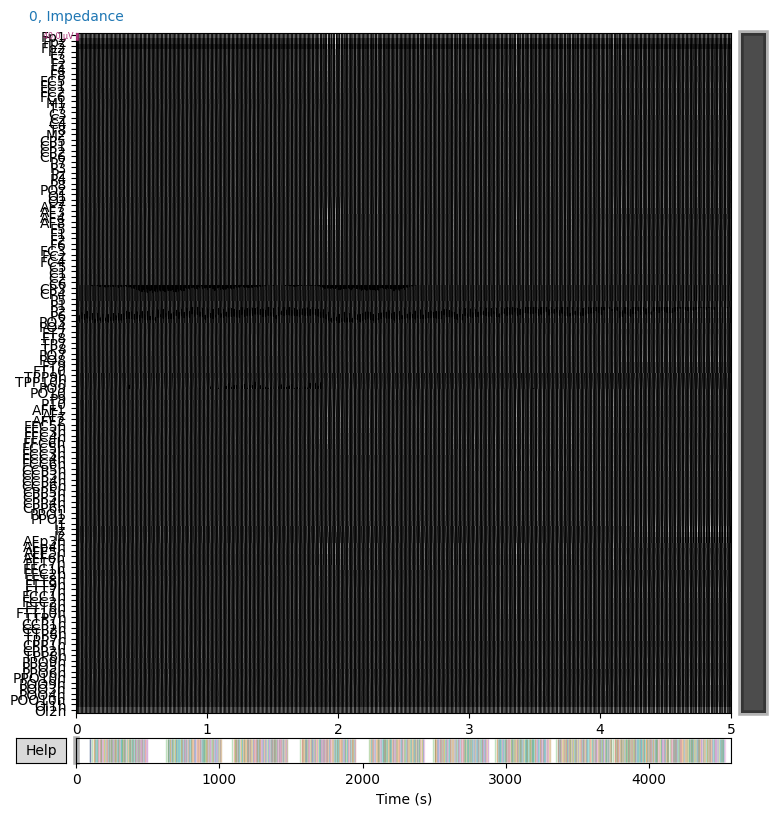

Opening raw-browser...


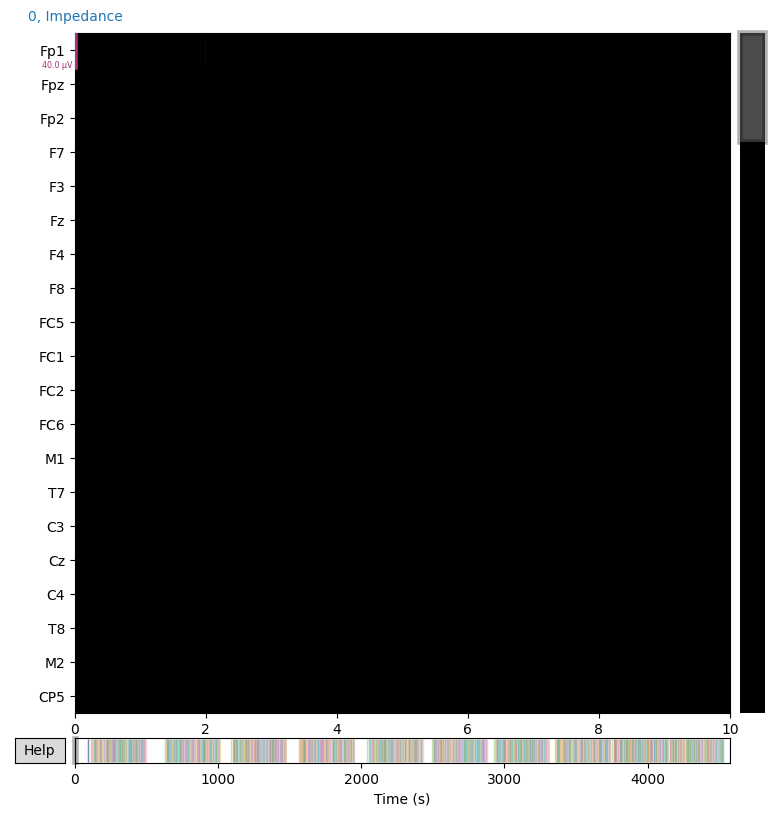

In [4]:
#%matplotlib qt 
psd = raw.plot_psd(fmin = 0,fmax=100, spatial_colors=True) # plots the power spectral density, only those below 50 Hz:  n_fft=2048,
psd.savefig(ppt_num+'_'+session+'_psd_raw.png')
# in frequency analyis should expect to see decreasing power with increasing frequencies
raw.plot(duration=5, n_channels=128) # input the timewindow and how many channels to include, 124 is eog removed
fig = raw.plot(block=True)
fig.savefig(ppt_num+'_'+session+'_raw.png')


## The Montage
It is useful to be able to visualise the layout of the electrodes when plotting data, and important to apply the montage to the raw data. Unfortunately ANT-Neuro montages, are particularly tricky to work with as they are not designed to be used in EEGLAB or mne. I am still working on making the montage compatiable. For now we have a rough montage to work with. We are using roughly a 10/20 format, and our reference is CPz.

To get an indication of what the montage looks like, you can plot this in 2D and 3D. We set the montage of the raw data, to be the ANT-Montage that we have loaded up.

Posts related to the problem (mostly for me to go about fixing this !)
 https://github.com/mne-tools/mne-python/issues/5661;  https://mne.tools/stable/auto_tutorials/intro/40_sensor_locations.html
 https://sccn.ucsd.edu/pipermail/eeglablist/2011/003759.html

The **channel names** used: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'HEOGR', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'HEOGL', 'PO3', 'PO4', 'VEOGU', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'VEOGL', 'FT9', 'FT10', 'TPP9h', 'TPP10h', 'PO9', 'PO10', 'P9', 'P10', 'AFF1', 'AFz', 'AFF2', 'FFC5h', 'FFC3h', 'FFC4h', 'FFC6h', 'FCC5h', 'FCC3h', 'FCC4h', 'FCC6h', 'CCP5h', 'CCP3h', 'CCP4h', 'CCP6h', 'CPP5h', 'CPP3h', 'CPP4h', 'CPP6h', 'PPO1', 'PPO2', 'I1', 'Iz', 'I2', 'AFp3h', 'AFp4h', 'AFF5h', 'AFF6h', 'FFT7h', 'FFC1h', 'FFC2h', 'FFT8h', 'FTT9h', 'FTT7h', 'FCC1h', 'FCC2h', 'FTT8h', 'FTT10h', 'TTP7h', 'CCP1h', 'CCP2h', 'TTP8h', 'TPP7h', 'CPP1h', 'CPP2h', 'TPP8h', 'PPO9h', 'PPO5h', 'PPO6h', 'PPO10h', 'POO9h', 'POO3h', 'POO4h', 'POO10h', 'OI1h', 'OI2h']


Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


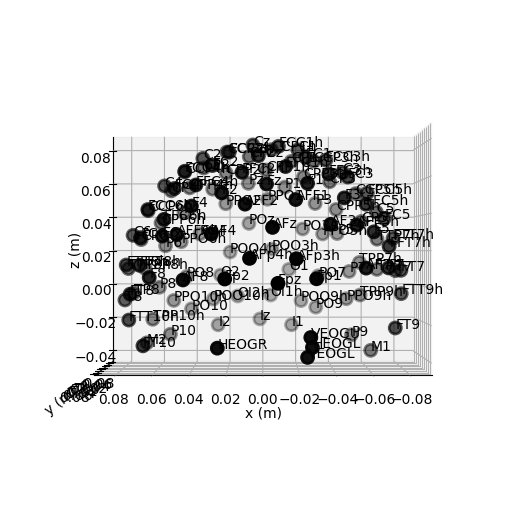

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


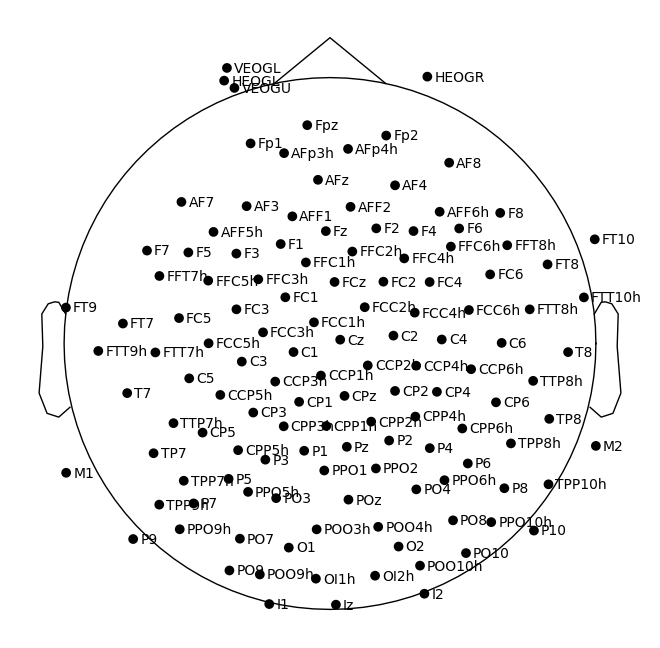

<RawEEGLAB | sub8_sess2.fdt, 124 x 4685084 (4575.3 s), ~4.33 GB, data loaded>

In [5]:
from mne import channels
#montage = channels.read_dig_hpts('C:\\Users\\hlw69\\Documents\\eeg_experiment\\Experiment\\CA-203.hpts')
#read_montage(kind = 'antNeuroMontage',path = 'C:\\Users\\hlw69\\Documents\\eeg_experiment\\Experiment\\antNeuroMontage.txt')
ant_montage = channels.read_custom_montage('edit.loc', coord_frame = 'head',head_size=0.08)#

#layout_from_raw = mne.channels.make_eeg_layout(raw.info)
fig = ant_montage.plot(kind='3d')
#fig.gca().view_init(azim=70, elev=15)  # set view angle
ant_montage.plot(kind='topomap', show_names=True)
raw.set_montage(ant_montage)
# raw.plot_sensors(ch_type='eeg')

# Reference in our case is CPz
#raw.set_eeg_reference(ref_channels = []'CPz'])

# (3) Cleaning the Data
## Detecting and Dealing with Bad Channels
We can look for bad channels by plotting them. Ones whch are completely flat indicate that the electrode was broken or impedance was insufficient to record a signal. These ones we should remove. We can fill in the missing data this creates by performing interpolation later on. Channels might also be bad due to having a significantly noiser signal than others. We could remove these, or we can leave them in and rely on ICA to deal with this in a later stage which means the whole channel does not have to be removed. So we can either remove, ignore or repair bad channels. It is important though, to at minimum, annotate channels which are bad.

Note that channel CCP1h is broken on the Large cap, so if the participant had the Large cap, always remove this particular channel.

In [ ]:
#%matplotlib qt 
#raw.plot(block=True)
if cap_size == 'large':
    raw.info['bads'] += ['CCP1h'] # ['names of channels to remove']
picks = mne.pick_types(raw.info, exclude='bads')  # picks can then be taken into epochs
raw.interpolate_bads(reset_bads=False)  # interpolate for the bad channel to fill in the missing data


### Ocular Artifacts
It is useful to visualise artifacts driven by eye muscles. We take a couple of the channels which are close to eyes *Fp1* and *Fp2*. We use these to estimate eog activity. By knowing what these artifacts look like, we can choose to exclude components that look like these in the later ICA analysis.

In [ ]:
eog_evoked = preprocessing.create_eog_epochs(raw, ch_name = ['Fp1', 'Fp2']).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()


### Filtering
We filter the data to remove power-line noise (*50 Hz*) via notch filtering, and then remove low-frequency drifts. Power-line noise can also be present at harmonic frequencies, hence we remove at 50, 100, 150Hz.
Low frequency noise arises from movements of the head, and also wires, as well as scalp perspiration. In contrast, high frequency noise relates to face and neck muscles as well as electromagnetic interference. We can choose whethe to remove low-frequence drifts, i.e. DC drifts.


In [ ]:
# Filter the data to remove power-line noise (50, 100, 150)          
notches = np.arange(50, 100, 150)
raw.notch_filter(notches, picks = 'eeg', filter_length = 'auto', phase = 'zero-double', fir_design = 'firwin')
# raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)

# Filter the data to remove low-frequency drifts (i.e. DC drifts):
raw.filter(l_freq=1., h_freq=None)

# Frequency analysis
#%matplotlib qt
filtered_psd = raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True) # y is decibals and x is frequency
filtered_psd.savefig(ppt_num+'_'+session+'_filtered_psd.png')

### ICA
We perform Independent Component Analaysis (ICA). This unmixes separate sources (channels) of data. This can be performed on filtered or filtered and epoched data. Though we recommend fitting to raw data. The data should be high pass filtered before fitting, as ICA is sensitive to low-frequency drifts. However if ICA is fit on epoched data, then it is recommended to high-pass filter but not to baseline correct the data. There are three options for the ICA algorithm, fastica, picard or infomax. Here we use Picard, which is faster and more robust.

We try and avoid fitting ICA on environmental artifacts that would dominate the variance and decomposition

In [16]:
#  you could plot the eye movements, 'FP1', 'FP2'

In [17]:
# first whitens the data, then obtains unmixing matrix, whitening the data means to uncorrelate the data
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
#average_ecg = create_ecg_epochs(raw).average()

reject = dict(mag=5e-12, grad=4000e-13) # this prevents ICA being fit on extreme environmental factors
amount_variance_explain = .99
num_components = 40
ica = mne.preprocessing.ICA(n_components=num_components, random_state=97, max_iter=800)#, method='picard')
ica.fit(raw, reject = reject)
#ica.exclude = []  # exclude components related to artifacts
#ica.plot_properties(raw)#, picks=ica.exclude)
#orig_raw = raw.copy()
#raw.load_data(preload=True )
#ica.apply(raw)
#ica_plot = ica.plot_components()
#ica_plot.savefig('ica_components.png')

#ica_raw = raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True) # y is decibals and x is frequency
#ica_raw.savefig('ica_raw.png')


Fitting ICA to data using 124 channels (please be patient, this may take a while)


<ipython-input-17-f6c06cc223e7>:9: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject)


Selecting by number: 40 components
Fitting ICA took 760.6s.


Method,fastica
Fit,44 iterations on raw data (4683776 samples)
ICA components,40
Explained variance,100.0 %
Available PCA components,124
Channel types,eeg
ICA components marked for exclusion,—


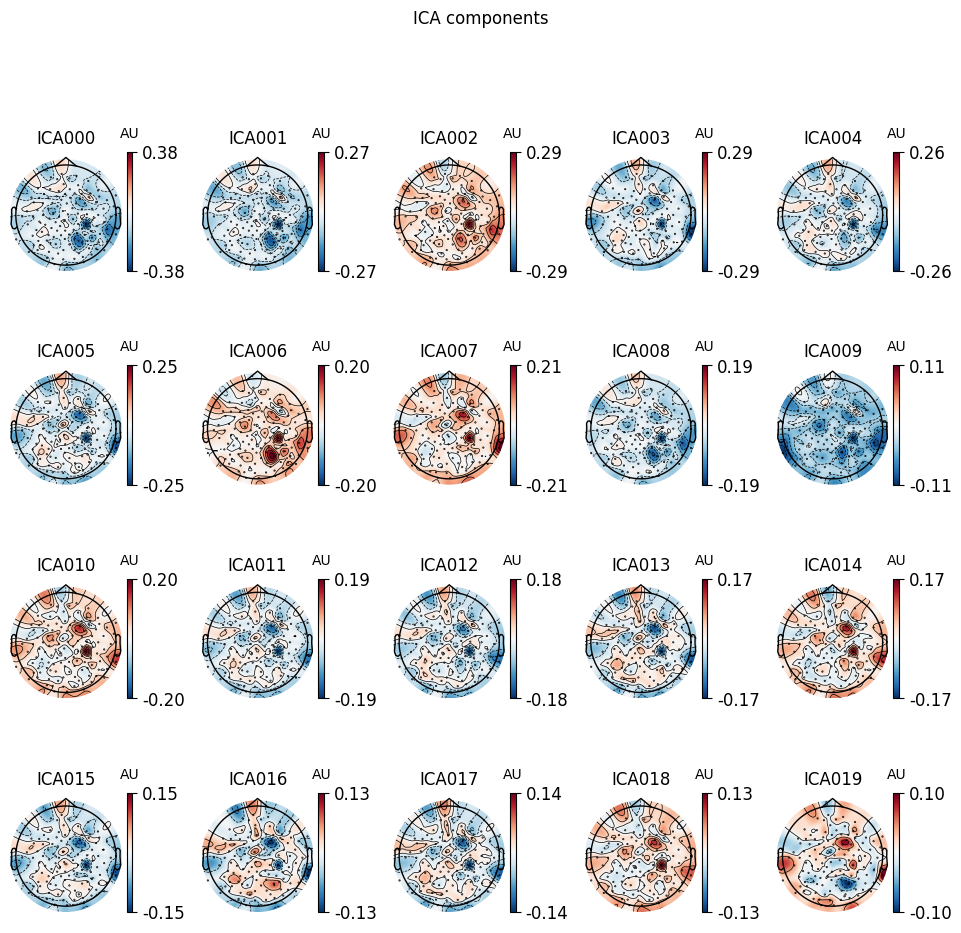

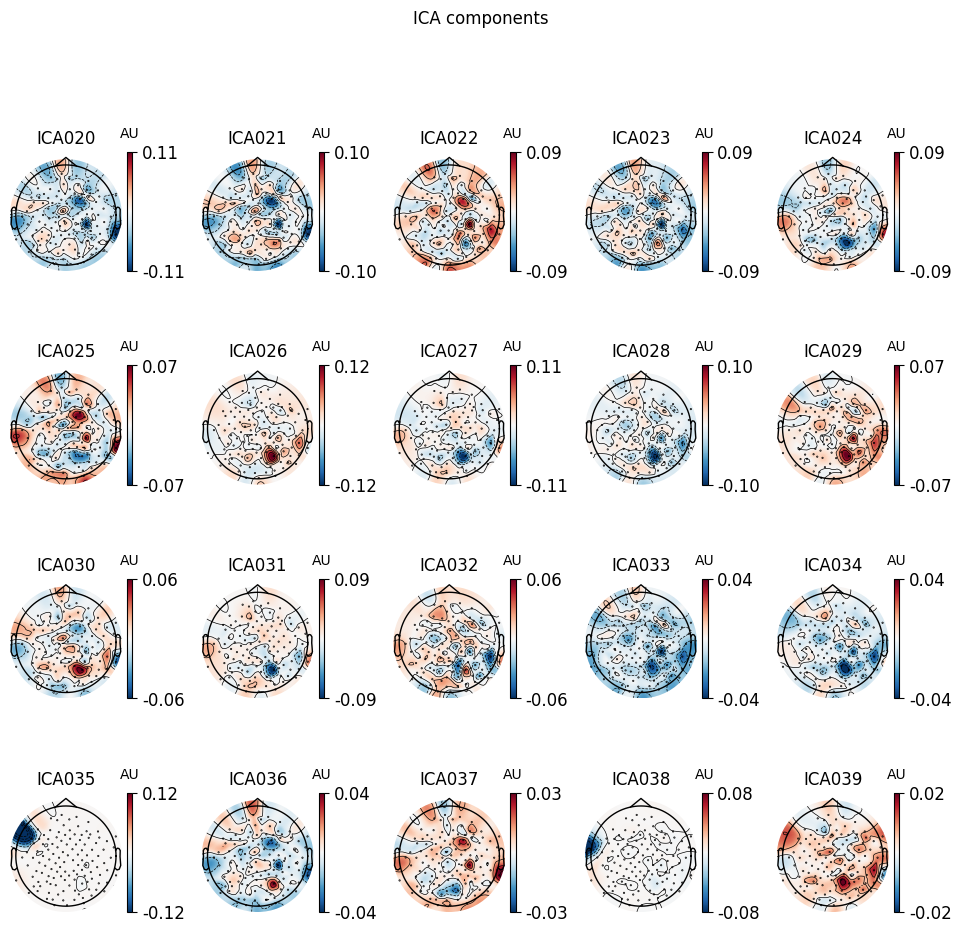

In [18]:
ica_plot = ica.plot_components(colorbar=True)

Using EOG channels: Fp1, F8
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.2

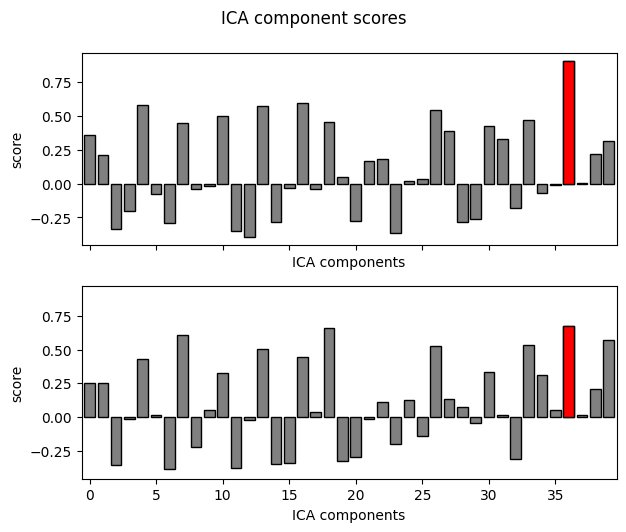

In [19]:
# identify EOG artifacts from ICA components
ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(raw, 
                                            ch_name=['Fp1', 'F8'], 
                                            threshold=ica_z_thresh)
ica.exclude = eog_indices

ica.plot_scores(eog_scores); # rejected ones are in red

Now we apply the ICA to the raw data

Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 1 ICA component
    Projecting back using 124 PCA components
Creating RawArray with float64 data, n_channels=40, n_times=4685084
    Range : 0 ... 4685083 =      0.000 ...  4575.276 secs
Ready.
Opening ica-browser...


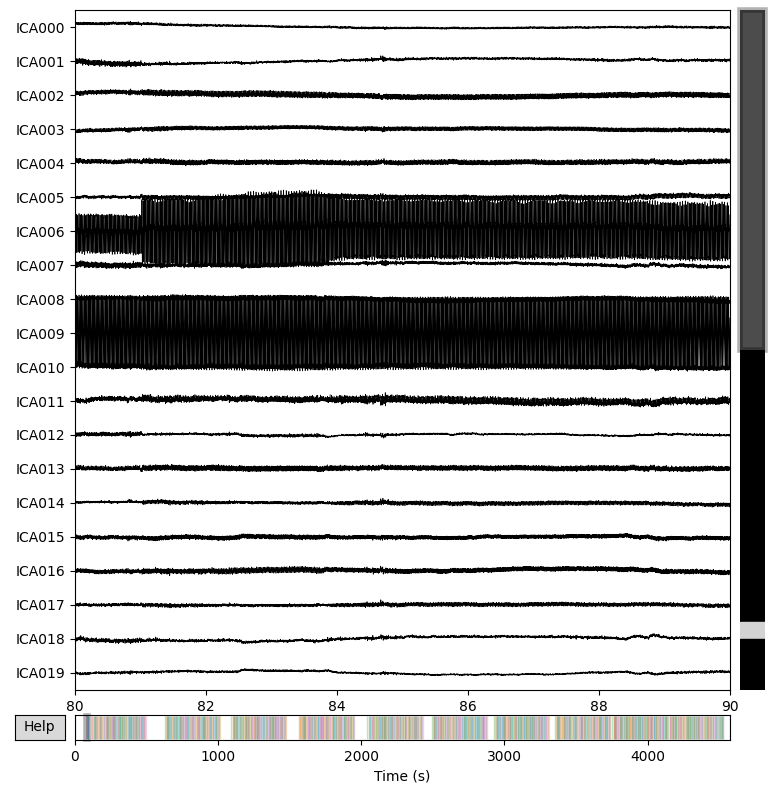

In [20]:
dimension_to_keep = 124
ica.apply(raw, n_pca_components = dimension_to_keep)

sources = ica.plot_sources(raw, start=80, stop=90)
#properties = ica.plot_properties(raw)#, picks=ica.exclude)
sources.savefig(ppt_num+'_'+session+'_sources.png')

#from autoreject import get_rejection_threshold

#reject = get_rejection_threshold(epochs_ica);


##  (4) Placeholder for Feature Extraction
Can consider, feature extraction in time domain, frequency domain or time-frequency domain (such as PSD estimated using Welch's method)


## (5) Placeholder for Feature Selection
Wrapper approach =

Filter approach = 

## (6) Placeholder for Dimensionality Reduction
Examples include LDA, ICA, PCA, Mutual Information

# (7) Epoching


In [21]:
events, event_ids = mne.events_from_annotations(raw, verbose = False)
print("The events...", events)
epochs = mne.Epochs(raw=raw, events=events, event_id=event_ids, preload=True, tmin = 0,tmax =4,baseline=None, event_repeated='merge')

print("The number of distinct events, not trials :", len(event_ids)) # this will give the number of distinct events, not the amount of trials
print("The event names ", event_ids)

The events... [[      0       0     100]
 [  96831       0     100]
 [  96833       0     202]
 ...
 [4634415       0     157]
 [4637495       0      33]
 [4685081       0     100]]
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
925 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 925 events and 4097 original time points ...
1 bad epochs dropped
The number of distinct events, not trials : 203
The event names  {'0, Imagination_a_flower_high_10###my_stream_name': 1, '0, Imagination_a_flower_high_11###my_stream_name': 2, '0, Imagination_a_flower_high_17###my_stream_name': 3, '0, Imagination_a_flower_high_23###my_stream_name': 4, '0, Imagination_a_flower_high_4###my_stream_name': 5, '0, Imagination_a_flower_high_5###my_stream_name': 6, '0, Imagination_a_flower_low_10###my_stream_name': 7, '0, Imagination_a_flower_low_13###my_stream_name': 8, 

Now we have the epochs extracted, we can delete the raw data to free up memory space.

In [ ]:
del raw # frees up space

## Grouping into Categories
We saw in the previous step that there are a huge number of unique events. They are currently not grouped into the 18 categories that we are interested in, which are combinations or Imagination or Perception; Flower or Penguin or Guitar; Sound or Text or Pictorial. The following code is clunky, but essentially sorts all of the event_ids into their corresponding category.

In [22]:
imag_flower_t = []
imag_penguin_t = []
imag_guitar_t = []
imag_flower_p = []
imag_guitar_p = []
imag_penguin_p = []
imag_flower_s = []
imag_guitar_s = []
imag_penguin_s = []
perc_flower_t = []
perc_guitar_t = []
perc_penguin_t = []
perc_flower_p = []
perc_guitar_p = []
perc_penguin_p = []
perc_flower_s = []
perc_guitar_s = []
perc_penguin_s = []

for id in event_ids:
    if 'Imagination' in id:
        if 'flower' in id:
            if '_t_' in id:
                imag_flower_t.append(id)
            elif '_image_'in id:
                imag_flower_p.append(id)
            elif '_a_' in id:
                imag_flower_s.append(id)
            else:
                print(id)
        elif 'guitar' in id:
            if '_t_' in id:
                imag_guitar_t.append(id)
            elif '_image_'in id:
                imag_guitar_p.append(id)
            elif '_a_'in id:
                imag_guitar_s.append(id)
            else:
                print(id)
        elif 'penguin' in id:
            if '_t_' in id:
                imag_penguin_t.append(id)
            elif '_image_'in id:
                imag_penguin_p.append(id)
            elif '_a_'in id:
                imag_penguin_s.append(id)
            else:
                print(id)
                
    
    
    if 'Perception' in id:
        if 'flower' in id:
           # print(id)
            if '_t_' in id:
                perc_flower_t.append(id)
            elif '_image_' in id:
                perc_flower_p.append(id)
            elif 'a_'in id or 'audio' in id:
                perc_flower_s.append(id)
            else:
                print(id)
        elif 'guitar' in id:
            if '_t_' in id:
                perc_guitar_t.append(id)
            elif '_image_'in id:
                perc_guitar_p.append(id)
            elif 'tiona_'in id or 'audio' in id:
                perc_guitar_s.append(id)
            else:
                print(id)
        elif 'penguin' in id:
            if '_t_' in id:
                perc_penguin_t.append(id)
            elif '_image_'in id:
                perc_penguin_p.append(id)
            elif 'tiona_'in id or 'audio' in id:
                perc_penguin_s.append(id)
            else:
                print(id)

event_list = [imag_flower_t,imag_penguin_t, imag_guitar_t, imag_flower_p,imag_guitar_p,
             imag_penguin_p,imag_flower_s, imag_guitar_s, imag_penguin_s,
            perc_flower_t, perc_guitar_t, perc_penguin_t, perc_flower_p,
            perc_guitar_p, perc_penguin_p, perc_flower_s, perc_guitar_s, perc_penguin_s]
print("There should be 18 conditions: ", len(event_list))
for li in event_list:
    print("Amount of different types in each condition ",len(li))

There should be 18 conditions:  18
Amount of different types in each condition  5
Amount of different types in each condition  5
Amount of different types in each condition  5
Amount of different types in each condition  3
Amount of different types in each condition  3
Amount of different types in each condition  3
Amount of different types in each condition  25
Amount of different types in each condition  26
Amount of different types in each condition  24
Amount of different types in each condition  5
Amount of different types in each condition  5
Amount of different types in each condition  5
Amount of different types in each condition  3
Amount of different types in each condition  3
Amount of different types in each condition  3
Amount of different types in each condition  25
Amount of different types in each condition  26
Amount of different types in each condition  24


Now we use the 'combine_event_ids' method to form new event categories in the original epochs data we have.

In [23]:
# merge all the trials into their conditions, do this inplace to save on memory load

mne.epochs.combine_event_ids(epochs, imag_flower_t, {'imag_flower_t': 300}, copy = False)
mne.epochs.combine_event_ids(epochs, imag_penguin_t, {'imag_penguin_t': 301}, copy = False)
mne.epochs.combine_event_ids(epochs, imag_guitar_t, {'imag_guitar_t': 302}, copy = False)

mne.epochs.combine_event_ids(epochs, imag_flower_p, {'imag_flower_p': 303}, copy = False)
mne.epochs.combine_event_ids(epochs, imag_penguin_p, {'imag_penguin_p': 304}, copy = False)
mne.epochs.combine_event_ids(epochs, imag_guitar_p, {'imag_guitar_p': 305}, copy = False)

mne.epochs.combine_event_ids(epochs, imag_flower_s, {'imag_flower_s': 306}, copy = False)
mne.epochs.combine_event_ids(epochs, imag_penguin_s, {'imag_penguin_s': 307}, copy = False)
mne.epochs.combine_event_ids(epochs, imag_guitar_s, {'imag_guitar_s': 308}, copy = False)


mne.epochs.combine_event_ids(epochs, perc_flower_t, {'perc_flower_t': 309}, copy = False)
mne.epochs.combine_event_ids(epochs, perc_penguin_t, {'perc_penguin_t': 310}, copy = False)
mne.epochs.combine_event_ids(epochs, perc_guitar_t, {'perc_guitar_t': 311}, copy = False)

mne.epochs.combine_event_ids(epochs, perc_flower_p, {'perc_flower_p': 312}, copy = False)
mne.epochs.combine_event_ids(epochs, perc_penguin_p, {'perc_penguin_p': 313}, copy = False)
mne.epochs.combine_event_ids(epochs, perc_guitar_p, {'perc_guitar_p': 314}, copy = False)

mne.epochs.combine_event_ids(epochs, perc_flower_s, {'perc_flower_s': 315}, copy = False)
mne.epochs.combine_event_ids(epochs, perc_penguin_s, {'perc_penguin_s': 316}, copy = False)
mne.epochs.combine_event_ids(epochs, perc_guitar_s, {'perc_guitar_s': 317}, copy = False)


Number of events,924
Events,"0, Impedance: 20, Impedance/9002, Amplifier reconnected: 10, end_baseline###my_stream_name: 100, start_baseline###my_stream_name: 109001, Amplifier disconnected: 1imag_flower_p: 50imag_flower_s: 50imag_flower_t: 50imag_guitar_p: 50imag_guitar_s: 50imag_guitar_t: 50imag_penguin_p: 50imag_penguin_s: 50imag_penguin_t: 50perc_flower_p: 50perc_flower_s: 50perc_flower_t: 50perc_guitar_p: 50perc_guitar_s: 50perc_guitar_t: 50perc_penguin_p: 50perc_penguin_s: 50perc_penguin_t: 50"
Time range,0.000 – 4.000 sec
Baseline,off


Because we added these 18 new event categories into the epochs data we already have, we want to remove all the redunant information.  Therefore we create a new epoch object, which includes only the 18 categories we are interested in.

In [24]:
# keep only new selection of epochs 


epochs_of_interest  = ['imag_flower_t','imag_penguin_t', 'imag_guitar_t', 'imag_flower_p','imag_guitar_p',
             'imag_penguin_p','imag_flower_s', 'imag_guitar_s', 'imag_penguin_s',
            'perc_flower_t', 'perc_guitar_t', 'perc_penguin_t', 'perc_flower_p',
            'perc_guitar_p', 'perc_penguin_p', 'perc_flower_s', 'perc_guitar_s', 'perc_penguin_s']
epochs_sub = epochs[epochs_of_interest]

In [25]:
print(epochs_sub) # should be between 35 to 40 for each category depending on how many blocks a participant got through

<Epochs |  900 events (all good), 0 - 4 sec, baseline off, ~3.41 GB, data loaded,
 'imag_flower_t': 50
 'imag_penguin_t': 50
 'imag_guitar_t': 50
 'imag_flower_p': 50
 'imag_penguin_p': 50
 'imag_guitar_p': 50
 'imag_flower_s': 50
 'imag_penguin_s': 50
 'imag_guitar_s': 50
 'perc_flower_t': 50
 and 8 more events ...>


## Editing the Durations
Epochs in mne are expected to all be the same length. That is why in the *mne.Epochs()* method to extract epochs from the raw data, we set *tmin=0* and *tmax=4*, which takes a 4 second segment for each event. However, in our dataset, the time segment varies depending on the condition:
* Imagine Orthographic =  4s
* Perception Orthographic = 3s
* Imagine Audio =  4s  
* Perception Audio = 2s
* Imagine Pictorial =  4s
* Perception Pictorial = 3s

In the following code, we create a new epochs object for each condition to adjust for the different durations. We should end up with 6 different epoch objects. Suggestion for how to do this was taken from https://mne.discourse.group/t/epochs-with-variable-durations-again/2449 and https://mail.nmr.mgh.harvard.edu/pipermail//mne_analysis/2013-December/001741.html

In [28]:
imagine_orthographic_epochs = epochs_sub[['imag_flower_t', 'imag_guitar_t', 'imag_penguin_t']].crop(tmin=0, tmax =4)
imagine_pictorial_epochs = epochs_sub[['imag_flower_p', 'imag_guitar_p', 'imag_penguin_p']].crop(tmin=0, tmax =4)
imagine_audio_epochs = epochs_sub[['imag_flower_s', 'imag_guitar_s', 'imag_penguin_s']].crop(tmin=0, tmax =4)
perception_orthographic_epochs = epochs_sub[['perc_flower_t', 'perc_guitar_t', 'perc_penguin_t']].crop(tmin=0, tmax =3)
perception_pictorial_epochs = epochs_sub[['perc_flower_p', 'perc_guitar_p', 'perc_penguin_p']].crop(tmin=0, tmax =3)
perception_audio_epochs = epochs_sub[['perc_flower_s', 'perc_guitar_s', 'perc_penguin_s']].crop(tmin=0, tmax =4)
#print(perception_pictorial_epochs)

<Epochs |  150 events (all good), 0 - 3 sec, baseline off, ~436.2 MB, data loaded,
 'perc_flower_p': 50
 'perc_penguin_p': 50
 'perc_guitar_p': 50>


# (8) Classification
## Example Decoding on Visual Perception
We select just the perception pictorial epochs, and split them into a train and test set

In [32]:
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from mne.decoding import CSP, Scaler, Vectorizer, cross_val_multiscore


# train test split: 80, 20

X = perception_pictorial_epochs.get_data()  # EEG signals: n_epochs, n_eeg_channels, n_times
y = perception_pictorial_epochs.events[:, -1]  # target: penguin vs guitar vs flower


clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver='liblinear')  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=3, n_jobs=1)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0 .1f%%' % (100 * score,))
# standardisation
#StandardScaler

#data features, particular bands?


[312 312 312 314 313 312 313 314 313 313 312 314 312 314 312 313 313 312
 313 313 312 312 314 314 313 312 314 313 312 314 312 312 314 314 314 313
 312 312 312 312 312 312 314 312 312 312 312 313 312 313 314 314 313 314
 312 312 313 313 313 312 313 314 312 312 313 312 313 313 312 312 313 314
 314 313 314 312 314 313 314 314 312 313 312 312 313 314 314 314 313 312
 314 313 314 313 312 313 313 314 314 313 313 313 314 312 314 312 313 314
 313 313 313 314 314 314 314 313 314 314 314 312 312 314 313 314 313 313
 312 312 313 314 312 314 314 313 312 313 314 314 313 313 312 313 314 314
 313 312 313 314 312 314]
Spatio-temporal: 22.7%


In [33]:
print(scores)

[0.36666667 0.23333333 0.06666667 0.1        0.36666667]


Save the preprocessed data in the .fif format

In [ ]:
raw_filt.save(data_dir + '/' + subject + '_' + session+ '-preprocessed.fif', 
              overwrite=True)

You can also convert epoch object into panda dataframe to make them easier to work with

In [ ]:
dataFrameOut = epochs[epochs['event_ids']]#.str.contains('Imagination')]
print(dataFrameOut)